In [14]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

from numpy import linalg as LA

from scipy import sparse
from scipy.sparse.linalg import spsolve

## la résolution de l’EDP de Black & Scholes pour le call européen standard en variable logarithmique pour les schémas d’Euler implicite.


- Discrétisation en espace sur $[-L, L]$ avec $L>>\log K:$ pour $N$ entier, on pose $h=\frac{2 L}{N}$, $y_i=-L+i h, i=0, \ldots, N$


- Les valeurs $u\left(\tau, y_i\right)$ recherchées sont approchées par le vecteur $U(\tau)=\left(u_i(\tau)\right)_{1 \leq i \leq N-1}$ tel que pour $i=1, \ldots, N-1$ :
$$
\begin{aligned}
\frac{d u_i}{d \tau}(\tau) & -\frac{\sigma^2}{2} \frac{u_{i+1}(\tau)-2 u_i(\tau)+u_{i-1}(\tau)}{h^2} \\
& -\left(r-\frac{\sigma^2}{2}\right) \frac{u_{i+1}(\tau)-u_{i-1}(\tau)}{2 h}+r u_i(\tau)=0
\end{aligned}
$$


Dans ce tp, on utlise le shéma de crank nischolson puisque il est plus géneral, et il suffit de changer le theta pour avoir le shéma d'Euler implicite ou explicite. 

- Crank-Nicholson $(\theta=\frac{1}{2})$ :
$$
(\mathbf{I}-\theta \Delta T \mathbf{A}) U^{j+1}=(\mathbf{I}+(1-\theta) \Delta T \mathbf{A}) U^j
$$

In [10]:
S0_min = 10
S0_max = 200
K = 80
r = 0.05
sigma = 0.08
T = 1
N = 100
M = 100

## résolution de l’EDP de Black & Scholes pour le call européen standard

In [11]:
# Crank Nicholson
def Crank_Nicholson(N,M):    
    # Passage en log prix
    y_max = np.log(S0_max)  
    y_min = np.log(S0_min)
    
 
    y,h = np.linspace(y_min, y_max,N,retstep=True)
    t,dt = np.linspace(0, T, M,retstep=True)
    S=np.exp(y)
    
    # Coefficients
    sig2,h2 = sigma*sigma,h*h
    theta = 1/2

    
    # Pour la matrice D1 = I + dt(1-theta)*A
    alpha1 = (1-theta)*(dt*(sig2/(2*h2) + sig2/(4*h) - r/(2*h)))
    beta1 = 1 + (1-theta)*(- dt*sig2/h2 - dt*r)
    gamma1 = (1-theta)*(dt*(sig2/(2*h2) - sig2/(4*h) + r/(2*h)))

    # Pour la matrice D2 = I - dt*theta*A
    alpha2 = theta*dt*(-sig2/(2*h2) + r/(2*h) -sig2/(4*h))
    beta2 = 1 + theta*(dt*sig2/h2 + dt*r)
    gamma2 = theta*dt*(-sig2/(2*h2) - r/(2*h) +sig2/(4*h))
    
    # Initialisation 
    W = np.zeros((N,M))

    # Condition initiale : Maturité de l'option pour tau = 0 -> t = T
    W[:,0] = np.max(S - K,0)
    

    for i in range(N):
        W[i,0] = max(0,np.exp(y_min + i*h) - K)
       
    
    for j in range(1,M):
        
        # Conditions aux bords :
        W[0,j] = 0  
        W[N-1,j] = np.exp(y_max) - K*np.exp(-r*j*dt)
    
        B = np.zeros(N-2)
        B[0] = dt*(-sig2/(2*h2) + r/(2*h) -sig2/(4*h))*W[0,j]
        B[-1] = dt*(-sig2/(2*h2) - r/(2*h) +sig2/(4*h))*W[-1,j-1] 
    
        D1 = sparse.diags([alpha1, beta1, gamma1], [-1, 0, 1], shape=(N-2, N-2)).tocsc()
        D2 = sparse.diags([alpha2, beta2, gamma2], [-1, 0, 1], shape=(N-2, N-2)).tocsc()
        W[1:(N-1),j] = spsolve( D2, (D1@W[1:(N-1),j-1] - B) )

    return(S,W)

In [12]:
def Price_BS(S,K,T,r,sigma,t=0): 
    d1 = (np.log(S/K)+(r+sigma**2/2.)*(T-t))/(sigma*np.sqrt(T-t)) 
    
    d2 = d1-sigma*np.sqrt(T-t)
    return S*norm.cdf(d1)-K*np.exp(-r*(T-t))*norm.cdf(d2)

# Grille de taille N*M pour le call par formule analytique 
def Call_BS(S0_min,S0_max,K,r,sigma,T,N,M):
 # Passage en log prix
    y_max = np.log(S0_max); y_min = np.log(S0_min)

    # Discrétisation
    y, h = np.linspace(y_min, y_max, N, retstep=True)
    t, dt = np.linspace(0, T, M, retstep=True)
    S = np.exp(y)
    
    C = np.zeros((N,M))
    
    C[:,0] = np.maximum(S - K,0) 
    C[N-1,:] = S0_max - K * np.exp(-r*t)
    
    for i in range(1,len(t)):
        C[:,i] = Price_BS(S,K,T,r,sigma,T-t[i])


    return S,C

##  le prix EDP et le prix de la formule de Black & Scholes en fonction de $S_0$

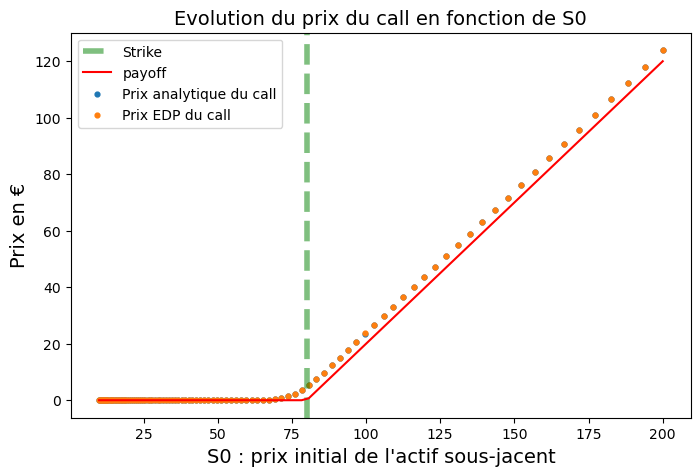

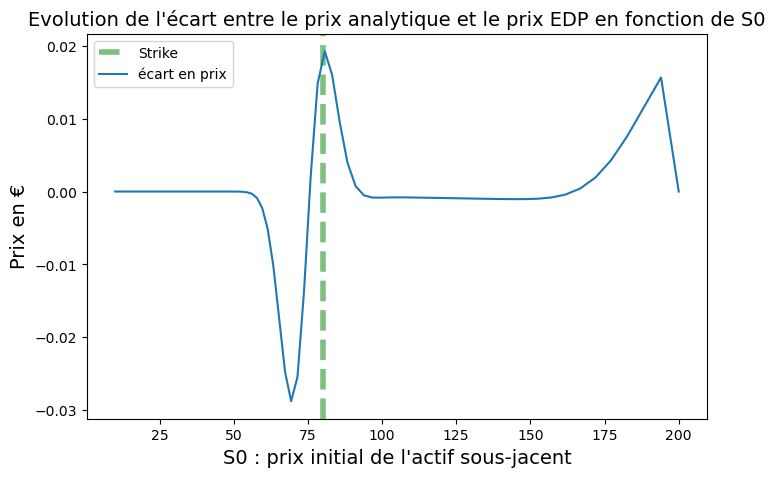

In [15]:
N=100
M=100

S,C = Call_BS(S0_min,S0_max,K,r,sigma,T,N,M)

S_euler,C_euler = Crank_Nicholson(N,M)

## figure 1 
plt.figure(figsize=(8,5))
plt.axvline(x=K, ymin=0, ymax=1, color='green', alpha=0.5, linestyle='--', linewidth=4, label='Strike')
dr = [0 if i<K else i-K for i in S]
plt.plot(S,dr,color="red",label='payoff')
plt.scatter(S, C[:,-1],label='Prix analytique du call',s=12)
plt.scatter(S_euler,C_euler[:,-1],label='Prix EDP du call',s=12)

plt.ylabel('Prix en €',fontsize=14)
plt.xlabel("S0 : prix initial de l'actif sous-jacent",fontsize=14)
plt.title("Evolution du prix du call en fonction de S0",fontsize=14)
plt.legend()

## figure 2 
plt.figure(figsize=(8,5))
plt.axvline(x=K, ymin=0, ymax=1, color='green', alpha=0.5, linestyle='--', linewidth=4, label='Strike')


plt.plot(S, C[:,-1]-C_euler[:,-1],label='écart en prix')


plt.ylabel('Prix en €',fontsize=14)
plt.xlabel("S0 : prix initial de l'actif sous-jacent",fontsize=14)
plt.title("Evolution de l'écart entre le prix analytique et le prix EDP en fonction de S0",fontsize=14)
plt.legend()

#### Commentaire
L'écart entre les deux prix devient non nul au voisinage du strike et aussi au voisinage du bord S0_max.

## L'erreur en norme $\|\cdot\|_{\infty}$ du prix EDP en fonction de $N$ (à $M$ suffisamment grand fixé)

Text(4, -6.5, 'Pente calculée  = -2.0')

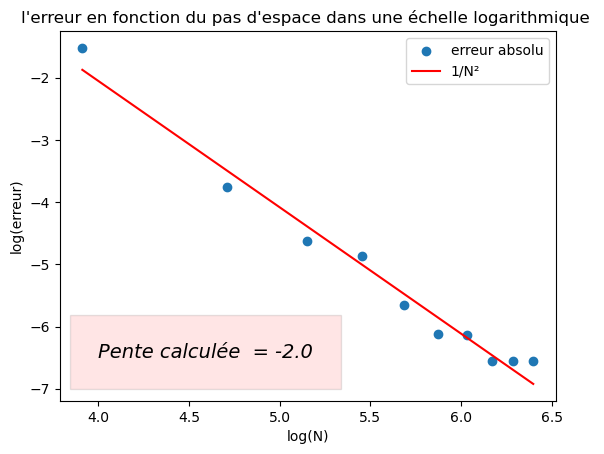

In [25]:
# Valeurs de N
N = np.linspace(50,600,10,dtype=int)

# Valeur de M (fixe)
M = 1300

C = Price_BS(S_euler,K,T,r,sigma,t=0)

erreur_list = []
for i in N :
    S_euler,C_euler = Crank_Nicholson(i,M)
    S,C = Call_BS(S0_min,S0_max,K,r,sigma,T,i,M)
    erreur_list.append(LA.norm((C_euler[:,-1]-C[:,-1]).flatten(),np.inf))

slope,intercept = np.polyfit(np.log(N),np.log(erreur_list),deg=1)

plt.scatter(np.log(N),np.log(erreur_list),label='erreur absolu')
plt.plot(np.log(N),intercept+slope*np.log(N),label='1/N²',color='red')
plt.legend()
plt.title("l'erreur en fonction du pas d'espace dans une échelle logarithmique ")
plt.ylabel("log(erreur)")
plt.xlabel("log(N)")

textstr = 'Pente calculée  = '+str(round(slope,1))

plt.text(4, -6.5, textstr, style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.1, 'pad': 20},fontsize=14)

#### Commentaire
On obtient numériquement une pente de valeur -2. L'ordre de l'erreur du schéma de Crank-Nicholson en espace est de deux (2). Cela signifie que l'erreur décroit à un taux de $\mathcal{O}(h^2)$, où $h$ représente la taille de la grille spatiale utilisée pour approximer la solution. En d'autres termes, en réduisant la taille de la grille spatiale par deux, l'erreur est divisée par quatre (4).

## L'erreur en norme $\|\cdot\|_{\infty}$ du prix EDP en fonction de $M$ (à $N$ suffisamment grand fixé)

Text(6.25, -6.2, 'Pente calculée  = -1.76')

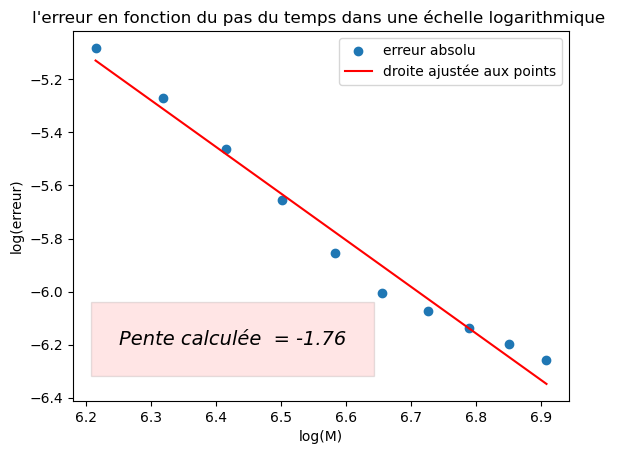

In [38]:
# Valeurs de M
M = np.linspace(500,1000,10,dtype=int)

# Valeur de N (fixe)
N = 1300

erreur_list = []
for i in M :
    S_euler,C_euler = Crank_Nicholson(N,i)
    S,C = Call_BS(S0_min,S0_max,K,r,sigma,T,N,i)
    erreur_list.append(LA.norm((C_euler-C).flatten(),np.inf))

slope,intercept = np.polyfit(np.log(M),np.log(erreur_list),deg=1)

plt.scatter(np.log(M),np.log(erreur_list),label="erreur absolu")
plt.plot(np.log(M),intercept+slope*np.log(M),label='droite ajustée aux points',color='red')
plt.legend()


plt.title("l'erreur en fonction du pas du temps dans une échelle logarithmique ")
plt.ylabel("log(erreur)")
plt.xlabel("log(M)")

textstr = 'Pente calculée  = '+str(round(slope,2))

plt.text(6.25, -6.2, textstr, style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.1, 'pad': 20},fontsize=14)

#### Commentaire
On obtient numériquement une pente de valeur -1.76, cette valeur peut etre arrondie à -2 afin que les résultats soient compatibles avec les résultats théoriques.

Le schéma du Crank-Nicolson en temps est un schéma d'approximation numérique de la solution d'une équation différentielle. L'ordre d'erreur du schéma du Crank-Nicolson en temps est d'ordre 2, c'est-à-dire que l'erreur est proportionnelle à $(\Delta t)^2$ où $\Delta t$ est la taille de la discrétisation en temps. Cela signifie que si on divise par deux la taille de la discrétisation en temps, on obtient une erreur quatre fois plus petite.

## l'erreur ponctuelle $\left|u_i^j-u\left(j \Delta T, y_i\right)\right|$ en fonction de $t=T-j \Delta T \in[0, T]$ et $S=e^{y_i} \in\left[e^{-L}, e^L\right]$.

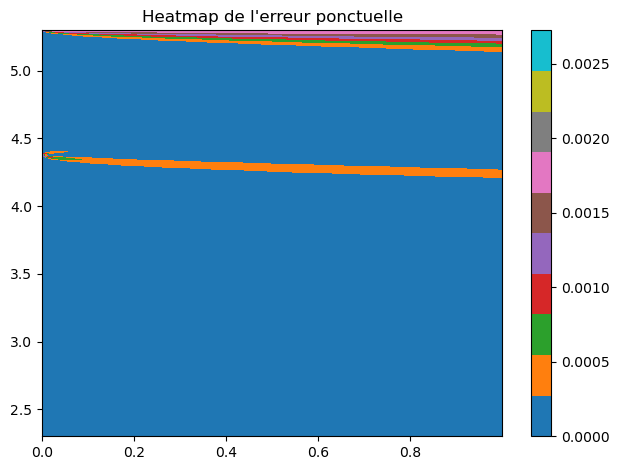

In [41]:
M = 1000
N = 1000

S_CN, C_CN = Crank_Nicholson(N,M)
S_BS,C_BS = Call_BS(S0_min,S0_max,K,r,sigma,T,N,M)

erreur = np.abs(C_CN-C_BS)

# make these smaller to increase the resolution
ymax,ymin = np.log(S0_max),np.log(S0_min)

dx, dy = 1/M, (ymax-ymin)/N

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[ymin:ymax:dy, 0:1:dx]
z = erreur
z_min, z_max = z.min(), abs(z).max()
fig, axs = plt.subplots(1, 1)

ax = axs
c = ax.pcolor(x, y, z, cmap='tab10', vmin=z_min, vmax=z_max)
ax.set_title("Heatmap de l'erreur ponctuelle" )
fig.colorbar(c, ax=ax)



fig.tight_layout()
plt.show()

#### Commentaire 

On observe une erreur dans la bande centrale de la grille ce qui correspond à la valeur du strike. On observe aussi une erreur au bord du haut